In [37]:
import tenzing
from tenzing.core.models import model_relation
from tenzing.core.typesets import tenzing_typeset, tenzingTypeset
from tenzing.core.model_implementations import *
from tenzing.core.typesets import infer_type, traverse_relation_graph, build_relation_graph
from tenzing.core.model_implementations.typesets import tenzing_standard

from collections import Counter
import pandas as pd
import numpy as np
from shapely import wkt
import datetime
from IPython.core.display import display, HTML
import networkx as nx
import itertools
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
relation = tenzing_integer.relations[tenzing_string]
series = pd.Series(['1', '2', np.nan])
operation = None
self = tenzing_integer
operation = operation if operation is not None else self.cast_op
idx = series.notna()
result = series.copy()
result[idx] = operation(series[idx])
result = result.infer_objects()
operation(series[idx])


0    1
1    2
dtype: int64

In [55]:
def get_series(series):
    if series.hasnans:
        ret = series[series.notna()]
    else:
        ret = series
    return ret
 
def get_series2(series):
    return series[series.notna()]


series = pd.Series([i for i in range(100000)] + [np.nan])
%timeit get_series(series)
%timeit get_series2(series)

1.77 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
839 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
series = pd.Series(['1', '2'])
operation = None
operation = operation if operation is not None else tenzing_integer.cast_op
idx = series.notna()
result = series.copy()
result[idx] = operation(series[idx]).infer_objects()
result

0    1
1    2
dtype: int64

In [25]:
s = pd.Series(range(10000000), dtype='object')
%timeit s.infer_objects()

1.4 s ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit pd.Series(s.tolist())

2.01 s ± 71.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
def string_is_geometry(series):
    """
        Shapely logs failures at a silly severity, just trying to suppress it's output on failures.
    """
    import logging
    from shapely import wkt
    logging.disable()
    try:
        result = all(wkt.loads(value) for value in series)
    except Exception:
        result = False
    finally:
        logging.disable(logging.NOTSET)

    return result

series = pd.Series(['a', 'b'])
string_is_geometry(series)

False

In [34]:
def evaluate_transform_path():
    pass
source_type = tenzing_string
target_type = tenzing_integer
#def get_type_inference_path(series, source_type, target_type, G):
paths = nx.all_shortest_paths(G, source=source_type, target=target_type)

def get_type_inference_path(base_type, series, G, path=[]):
    path.append(base_type)
    for tenz_type in G.successors(base_type):
        if G[base_type][tenz_type]['relationship'].is_relation(series):
            new_series = G[base_type][tenz_type]['relationship'].transform(series)
            return get_type_inference_path(tenz_type, new_series, G, path)
    return path


get_type_inference_path(source_type, series, G)
        


[tenzing_string, tenzing_float]

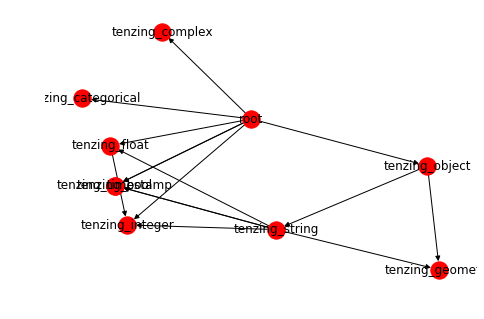

In [21]:
nx.draw_kamada_kawai(G, with_labels=True)

In [14]:
from tenzing.core.model_implementations.typesets import tenzing_standard

df = pd.DataFrame({'Col 1': range(3), 
                   'Col 2': [2 * i for i in range(3)], 
                   'Col 3': ['howdy', 'howdy', 'doody'],
                   'times': pd.to_datetime([datetime.date(2011,1,1), datetime.date(2012, 1, 1), datetime.date(2013,1,1)])})
x = tenzing_standard()
x.prep(df)
summer = x.summarize(df)


In [15]:
x = tenzing_standard()
x.prep(df)
y = x.summary_report(df)
y

Number of Observations,3
Number of Variables,4
tenzing_integer,2
tenzing_object,1
tenzing_timestamp,1
nunique,3.0
mean,1.0
std,1.0
max,2.0
min,0.0
median,1.0


In [17]:

from pandas_profiling import ProfileReport
ProfileReport(df)


/Users/ian/anaconda3/envs/tenzing/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Number of variables,4
Number of observations,3
Total Missing (%),0.0%
Total size in memory,176.0 B
Average record size in memory,58.7 B
Numeric,1
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,1


In [ ]:
types = tenzing_standard().types
series = df['Col 3']
[tenzing_type for tenzing_type in types if series in tenzing_type]

In [ ]:
x.relation_map

In [ ]:
from tenzing.core.models import tenzing_model

type(tenzing_model)

In [ ]:
tenzing_integer

In [ ]:
import pandas as pd
import numpy as np
x = pd.Series([1,2,3, np.nan])

print(x in tenzing_integer)
print(x in tenzing_float)

In [ ]:
int_float_relation = model_relation(tenzing_float, lambda x: False, lambda x: False)
tenzing_float.register_relation(int_float_relation)

In [3]:
import numpy as np

x = pd.Series(list(range(10000)))
%timeit x.astype(np.float)
%timeit x.astype(float)

103 µs ± 9.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
99.5 µs ± 4.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [4]:
x.astype(int).nbytes

80000

In [5]:
test_series = pd.Series([pd.datetime(2010, 1, 1), pd.datetime(2010, 8, 2), pd.datetime(2011, 2, 1), np.nan])
tenzing_timestamp.summarize(test_series)

{'nunique': 3,
 'min': Timestamp('2010-01-01 00:00:00'),
 'max': Timestamp('2011-02-01 00:00:00'),
 'n_records': 4,
 'perc_unique': 1.0,
 'range': Timedelta('396 days 00:00:00'),
 'na_count': 1,
 'perc_na': 0.25}

In [13]:
root_types = [tenzing_bool, tenzing_float, tenzing_object,
                      tenzing_complex, tenzing_categorical, tenzing_timestamp,
                      tenzing_integer]

In [14]:
[node.edge for s_node in root_types for to, node in s_node.relations.items()]

[(tenzing_float, tenzing_integer)]

In [15]:
root_types[-1].relations.items()

dict_items([(tenzing_float, <tenzing.core.models.model_relation object at 0x113fdbd30>)])

In [16]:
root_types

[tenzing_bool,
 tenzing_float,
 tenzing_object,
 tenzing_complex,
 tenzing_categorical,
 tenzing_timestamp,
 tenzing_integer]

In [20]:
pd.Series(['1.0', '2.0']).astype(float)

0    1.0
1    2.0
dtype: float64

In [6]:
series = pd.Series([1.0, 2.0, np.nan]).astype('str')
#series = pd.Series(range(20)).astype('str')

In [7]:
from tenzing.core.typesets import infer_type, traverse_relation_graph, build_relation_graph
from tenzing.core.model_implementations.typesets import tenzing_standard

G = tenzing_standard().relation_map

In [8]:
series_type = traverse_relation_graph(series, G)
inferred_type = infer_type(series_type, series, G)

In [9]:
series_type

tenzing_string

In [10]:
inferred_type

tenzing_float

In [11]:
def infer_type(base_type, series, G):
    print(series.dtype)
    for tenz_type in G.successors(base_type):
        relation = G[base_type][tenz_type]['relationship']
        if relation.is_relation(series):
            new_series = relation.transform(series)
            return infer_type(tenz_type, new_series, G)
    return base_type
infer_type(tenzing_string, series, G)

object
object


tenzing_float

In [12]:
G[tenzing_float][tenzing_string]['relationship'].transformer

KeyError: tenzing_string

In [75]:
relation = G[tenzing_string][tenzing_float]['relationship']

ns = relation.friend_model.get_series(series)
relation.transform(ns)

0    None
1    None
2    None
dtype: object

0    1.0
1    2.0
2    nan
dtype: object

In [86]:
from tenzing.utils import singleton, test_utils
class model_relation:
    """
    Hub and spoke model - these are relationships of the form
    friend_model -> model of model_relation

    """
    def __init__(self, model, friend_model, relationship=None, transformer=None):
        self.model = model
        self.friend_model = friend_model
        self.edge = (self.friend_model, self.model)
        self.relationship = relationship if relationship else self.model.__contains__
        self.transformer = transformer if transformer else self.model.cast

    def is_relation(self, obj):
        return self.relationship(self.friend_model.get_series(obj))

    def transform(self, obj):
        return self.transformer(self.friend_model.get_series(obj))

r = model_relation(tenzing_string, tenzing_object)
ns = r.friend_model.get_series(series)
ns.astype(str)

0    1.0
1    2.0
2    nan
dtype: object

In [77]:
series.astype('object')

0    1.0
1    2.0
2    nan
dtype: object

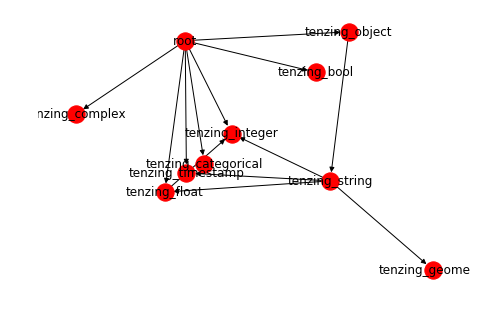

In [59]:
nx.draw_kamada_kawai(G, with_labels=True)

In [57]:
G[tenzing_object]

AtlasView({tenzing_string: {'relationship': <tenzing.core.models.model_relation object at 0x11667ff28>}})